In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('../src/')
import models
import generation_utils
import tokenizer
import data_utils
import metrics_utils
from utils import get_best_checkpoint
from tqdm.auto import tqdm
import itertools

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
pd.set_option('display.max_colwidth', 999)
pd.set_option('display.max_rows', 9999)

In [4]:
device = torch.device('cuda')

In [5]:
base_path = '../models/300s/checkpoints/19_3.3590.pt'#5825_0.0000.pt'

In [6]:
# checkpoint = get_best_checkpoint(base_path)
checkpoint = torch.load(base_path)

In [7]:
args = checkpoint['args']

In [8]:
t = tokenizer.Tokenizer(base = args['data']['base'], model_type=args['model_type'])

In [9]:
args.keys()

dict_keys(['data', 'model_type', 'pretrained_path', 'model_args', 'optimizer', 'scheduler', 'loader', 'io', 'metrics', 'verbose', 'wandb', 'resume_training', 'tokenizer'])

In [10]:
model = models.Factorizer(n_tokens = args['tokenizer']['n_tokens'], 
                          pad_token_id = args['tokenizer']['pad_token_id'],
                          **args['model_args'])
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

Factorizer(
  (src_embedding): TransformerEmbedding(
    (embedding): Embedding(14, 128)
  )
  (tgt_embedding): TransformerEmbedding(
    (embedding): Embedding(14, 128)
  )
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiHeadRelativeAttention(
            (w_q): Linear(in_features=128, out_features=128, bias=False)
            (w_k): Linear(in_features=128, out_features=128, bias=False)
            (w_v): Linear(in_features=128, out_features=128, bias=False)
            (out_proj): Linear(in_features=128, out_features=128, bias=False)
            (pe_mod): PositionalEncoding(
              (dropout): Dropout(p=0.05, inplace=False)
            )
            (w_k_pos): Linear(in_features=128, out_features=128, bias=False)
          )
          (linear1): Linear(in_features=128, out_fe

In [11]:
np.sum([np.prod(p.size()) for p in model.parameters()])

1209230

In [12]:
def make_plot_from_pairs(pairs, sample_pct=1, n_beams=5):
    addition_df = metrics_utils.form_addition_df(model, t, device, args['data']['base'], pairs, args['model_args']['max_decode_size'], n_beams, temperature=1.0, sample_pct=sample_pct)
    
    aggd_by_input_str = addition_df.groupby('input_str').agg({
        'n1' : 'first',
        'n2' : 'first',
        'pred_is_right' : metrics_utils.get_index_first_true
    })
    metrics_utils.addition_accuracy_plot(aggd_by_input_str, n_beams)
    return addition_df

In [13]:
# def make_plot_from_pairs(pairs, sample_pct=1, n_beams=5):
#     addition_df = metrics_utils.form_addition_df(model, t, device, args['data']['base'], pairs, args['model_args']['max_decode_size'], n_beams, temperature=1.0, sample_pct=sample_pct)
#     metrics_utils.addition_accuracy_plot(addition_df, n_beams)

  0%|          | 0/601 [00:00<?, ?it/s]

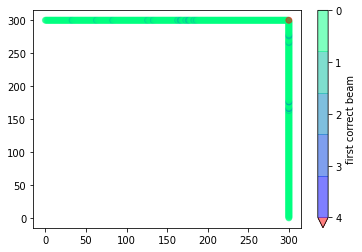

In [14]:
train_addition_df = make_plot_from_pairs(np.load('../data/addition/oos_data_299.npy'), sample_pct=1)

  0%|          | 0/6649 [00:00<?, ?it/s]

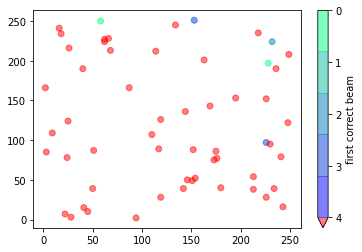

In [15]:
test_addition_df = make_plot_from_pairs(np.load('../data/addition_256_test.npy'), sample_pct=.01)

  0%|          | 0/4680 [00:00<?, ?it/s]

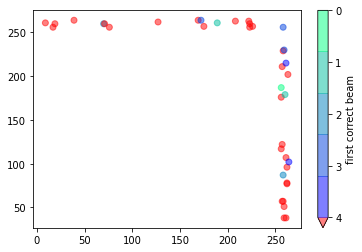

In [16]:
oos_addition_df = make_plot_from_pairs(np.load('../data/addition_256_oos.npy'), sample_pct=.01)

In [17]:
number_pairs = list(itertools.product(list(range(280, 320)), repeat=2))

  0%|          | 0/1600 [00:00<?, ?it/s]

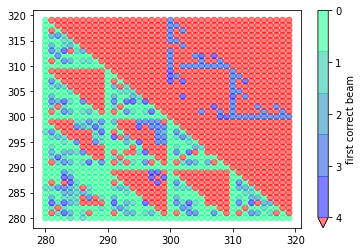

In [18]:
bounadry_addition_df = make_plot_from_pairs(number_pairs, sample_pct=1)

159600


  0%|          | 0/159600 [00:00<?, ?it/s]

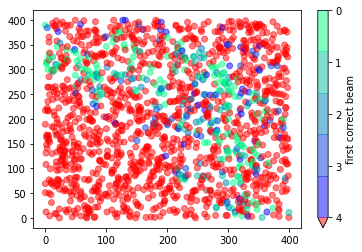

In [19]:
pairs = list(itertools.permutations(list(range(400)), 2))
print(len(pairs))
sample_pct = .01
n_beams = 5
random_addition_df = make_plot_from_pairs(pairs, sample_pct, n_beams)

In [20]:
sys.exit()

SystemExit: 

c:\users\hdnfd\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py:3426: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### Explore the model a little

In [ ]:
embeddings = model.src_embedding.embedding.weight.data.cpu().numpy()

In [ ]:
tokens = [''.join(t.decode([i], decode_special=True)) for i in range(len(t))]
special_tokens = set(['+', '_', '>', '.'])
tokens = np.array([tok if tok in special_tokens else data_utils.base2dec([int(tok)], args['data']['base']) for tok in tokens])

In [ ]:
embeddings.shape

In [ ]:
tokens.shape

In [ ]:
tokens

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne = TSNE()
embeddings_for_plot = tsne.fit_transform(embeddings)

In [ ]:
plt.scatter(embeddings_for_plot[:,0], embeddings_for_plot[:,1])
ax = plt.gca()
for tok, (x,y) in zip(tokens, embeddings_for_plot):
    fontsize = 12 if not tok in ['.', '_'] else 24
    ax.annotate(tok, (x+.3,y), fontsize=fontsize)
plt.show()

## Cosine Similarity
* Some embeddings have relatively simlar cosine similarities

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
cs_sim_mat = cosine_similarity(embeddings)
cs_sims = np.triu(cs_sim_mat, 1).ravel()
cs_sims = cs_sims[~np.isclose(cs_sims, 0)]

In [ ]:
plt.title('cosine simiarlty of embeddings')
pd.Series(cs_sims).hist()
plt.show()

In [ ]:
fig = plt.gcf()
fig.set_size_inches(20, 20)
ax = plt.gca()
plt.colorbar(ax.matshow(np.clip(cs_sim_mat, a_min=-1, a_max=cs_sim_mat[cs_sim_mat<.99].max()*1.1)), ax=ax)
ax.set_xticks(np.arange(cs_sim_mat.shape[0]))
ax.set_yticks(np.arange(cs_sim_mat.shape[0]))
ax.set_xticklabels(tokens[:cs_sim_mat.shape[0]])
ax.set_yticklabels(tokens[:cs_sim_mat.shape[0]])
plt.show()

## See what the attention looks at

In [ ]:
example_row = generation_utils.model_add(1, 1, args['data']['base'], model, t, device, args['model_args']['max_decode_size'], n_beams = 1, temperature=1, return_type='df')

In [ ]:
example_row

In [ ]:
input = t.encode(data_utils.form_input_addition(example_row['n1'].iloc[0], example_row['n2'].iloc[0], args['data']['base']))
# tgt = t.encode(data_utils.dec2base(example_row['pred_num'].iloc[0].replace('_', '').strip().split(' ')))
tgt = t.encode(data_utils.form_label_addition(example_row['pred_num'].iloc[0], 0, args['data']['base']))

In [ ]:
input = torch.tensor(input).unsqueeze(0).to(device)
tgt = torch.tensor(tgt).unsqueeze(0).to(device)

In [ ]:
with torch.no_grad():
    (memory, encoder_attn_weights), memory_key_padding_mask = model.encode(input, need_weights=True)

In [ ]:
memory.size(), memory_key_padding_mask.size(), encoder_attn_weights.size()

In [ ]:
res, mem_attn, self_attn = model.decode(tgt, memory.repeat(1, tgt.size(0), 1), memory_key_padding_mask.repeat(tgt.size(0), 1), return_enc_dec_attn=True)

In [ ]:
res.size(), mem_attn.size(), self_attn.size()

In [ ]:
mem_label = t.decode(input[0].data.cpu().numpy().tolist(), decode_special=True).split(' ')
tgt_label_attended_to = t.decode(tgt[0].data.cpu().numpy().tolist(), decode_special=True).split(' ')
tgt_label_attended_for = t.decode(tgt[0].data.cpu().numpy().tolist(), decode_special=True).split(' ')

In [ ]:
mem_label

In [ ]:
tgt_label_attended_to

In [ ]:
tgt_label_attended_for

In [ ]:
import matplotlib as mpl
def show_attn(fig, ax, matrix, attn_type, title):
    ax.set_title(title)
    
    ax.set_ylabel('Predicting the next token')
    ax.set_xlabel('Attending to this token')
    
    if attn_type=='encoder_self':
        ax.set_yticks(np.arange(len(mem_label)))
        ax.set_yticklabels(labels=mem_label, fontsize=16)
        
        ax.set_xticks(np.arange(len(mem_label)))
        ax.set_xticklabels(labels=mem_label, fontsize=16)
    elif attn_type=='decoder_self':
        ax.set_yticks(np.arange(len(tgt_label_attended_for)))
        ax.set_yticklabels(labels=tgt_label_attended_for, fontsize=16)
        
        ax.set_xticks(np.arange(len(tgt_label_attended_to)))
        ax.set_xticklabels(labels=tgt_label_attended_to, fontsize=16)
    elif attn_type=='mem':
        ax.set_yticks(np.arange(len(tgt_label_attended_for)))
        ax.set_yticklabels(labels=tgt_label_attended_for, fontsize=16)
        
        ax.set_xticks(np.arange(len(mem_label)))
        ax.set_xticklabels(labels=mem_label, fontsize=16)
    else:
        raise ValueError(f'attn type {attn_type} not understood')

    
    
    im = ax.imshow(matrix, cmap='Blues')
    fig.colorbar(im, ax=ax)

    
#     if 'self' in attn_type:
#         fig.set_size_inches(7,7)
#     else:
#         fig.set_size_inches(4,7)

In [ ]:
encoder_self_attn.size()

In [ ]:
fig, ax = plt.subplots(encoder_self_attn.size(0), encoder_self_attn.size(1))

for i in range(encoder_self_attn.size(0)):
    for j in range(encoder_self_attn.size(1)):
        title = '%s Layer: %d Head: %d'%('Encoder Self Attention', i,j)
        show_attn(fig, ax[i,j], encoder_self_attn[i][j].data.cpu().numpy(), 'encoder_self', title)
fig.set_size_inches(36,36)
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(mem_attn.size(0), mem_attn.size(1))

for i in range(mem_attn.size(0)):
    for j in range(mem_attn.size(1)):
        title = '%s Layer: %d Head: %d'%('Mem', i,j)
        show_attn(fig, ax[i,j], mem_attn[i][j].data.cpu().numpy(), 'mem', title)
fig.set_size_inches(36,36)
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(self_attn.size(0), self_attn.size(1))

for i in range(self_attn.size(0)):
    for j in range(self_attn.size(1)):
        title = '%s AttentionLayer: %d Head: %d'%('Self', i,j)
        show_attn(fig, ax[i,j], np.clip(self_attn[i][j].data.cpu().numpy(), a_min=0, a_max=.6), 'decoder_self', title)
fig.set_size_inches(36,36)
fig.tight_layout()